`Name:` Chris Andrei Irag

`Section:` DS4A

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

df = pd.read_csv("Sunspots_.csv").drop("Unnamed: 0", axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3247,2019-08-31,0.5
3248,2019-09-30,1.1
3249,2019-10-31,0.4
3250,2019-11-30,0.5


We load in the data 'Sunspots_.csv' which has two columns, `Date` and `Monthly Mean Total Sunspot Number`. `Date` has a monthly temporal resolution.

## Exploratory Data Analysis

Text(0.5, 1.0, 'Monthly Mean Total Sunspot Number - Full Dataset')

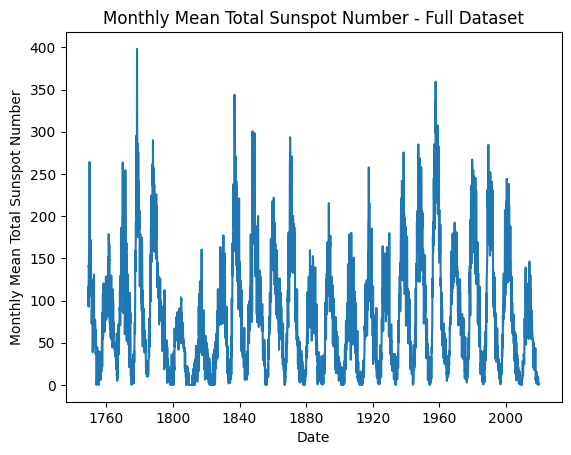

In [22]:
sns.lineplot(df, x="Date", y="Monthly Mean Total Sunspot Number")
plt.title("Monthly Mean Total Sunspot Number - Full Dataset")

The whole dataset doesn't seem to have any seasonality but shows some cyclicity.

In [3]:
# Only get the 5 most recent years
filtered_df = df[df['Date'] > df["Date"].max() - pd.DateOffset(years=5)].reset_index().drop("index", axis=1)
filtered_df

,Date,Monthly Mean Total Sunspot Number
0,2015-01-31,93.0
1,2015-02-28,66.7
2,2015-03-31,54.5
3,2015-04-30,75.3
4,2015-05-31,88.8
5,2015-06-30,66.5
6,2015-07-31,65.8
7,2015-08-31,64.4
8,2015-09-30,78.6
9,2015-10-31,63.6


Text(0.5, 1.0, 'Monthly Mean Total Sunspot Number - Last 5 Years')

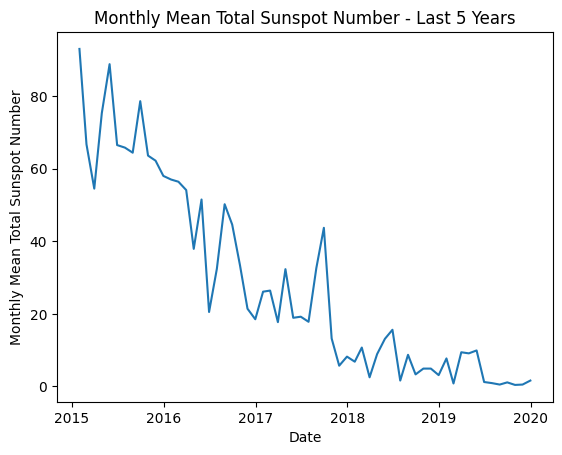

In [21]:
sns.lineplot(filtered_df, x="Date", y="Monthly Mean Total Sunspot Number")
plt.title("Monthly Mean Total Sunspot Number - Last 5 Years")

However, with filtered data from the last five years, there is a downward trend.

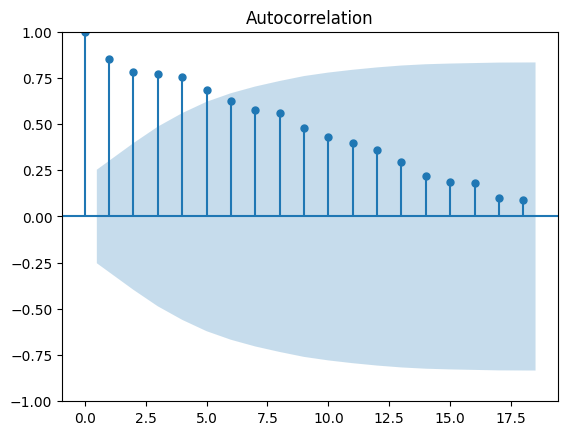

In [5]:
plt.show(plot_acf(filtered_df["Monthly Mean Total Sunspot Number"]))

Plotting the ACF shows us that their is a clear trend and distribution change over time, and will require differencing for ARIMA fitting.

In [6]:
df["Date"]

0      1749-01-31
1      1749-02-28
2      1749-03-31
3      1749-04-30
4      1749-05-31
          ...    
3247   2019-08-31
3248   2019-09-30
3249   2019-10-31
3250   2019-11-30
3251   2019-12-31
Name: Date, Length: 3252, dtype: datetime64[ns]

In [7]:
df["Monthly Mean Total Sunspot Number"].describe()

count    3252.000000
mean       82.070695
std        67.864736
min         0.000000
25%        24.200000
50%        67.750000
75%       122.700000
max       398.200000
Name: Monthly Mean Total Sunspot Number, dtype: float64

Text(0.5, 1.0, 'Distribution of Monthly Mean Total Sunspot Number')

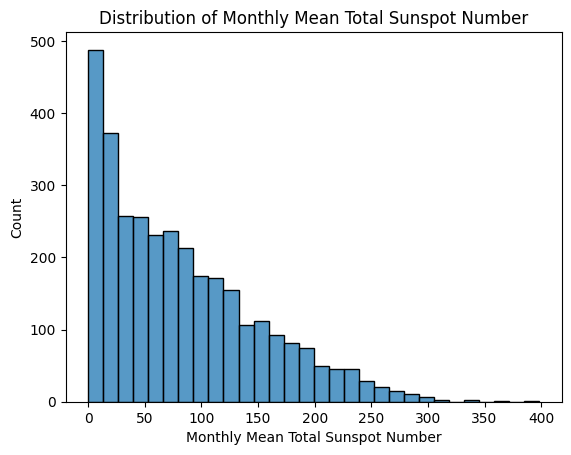

In [20]:
sns.histplot(df["Monthly Mean Total Sunspot Number"].to_list())
plt.xlabel("Monthly Mean Total Sunspot Number")
plt.title("Distribution of Monthly Mean Total Sunspot Number")

The data shows a non-normal distribution.

EDA Summary

- The time series data has a monthly temporal resolution.
- There is a downward trend.
- The data is not stationary according to the ACF plot and will need differencing
- The monthly mean total sunspot counts is not normally distributed.

# Modeling

We'll use SARIMA to model our problem, which we will computationally optimize by trying out combinations of varying orders of AR(p) and MA(q) models as well as the seasonal components P, D, Q, s. We will only be differencing the data once so we'll use I(d) and I(D) of order one.

These combinations are simply a cartesian product of all choices for each parameter. Which will be represented as `range` objects in the `SARIMAOptimizer` class. The `SARIMAOptimizer` class `_combinations` property we can call to get all tuple cartesian combinations of our parameters, and an `optimize` method that finds the model configuration that best minimizes Akaike Information Criterion (AIC) score. The optimization results are stored as an instance property `self.results`.

In [ ]:
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm

type AR_p = range
type I_d = range
type MA_q = range
type Order = tuple[AR_p, I_d, MA_q]

type AR_P = range
type I_D = range
type MA_Q = range
type periods_s = range
type SeasonalOrder = tuple[AR_P, I_D, MA_Q, periods_s]

type OrderCombination = tuple[int, int, int]
type SeasonalOrderCombination = tuple[int, int, int, int]
type Combination = tuple[OrderCombination, SeasonalOrderCombination]
type AICScore = float
type Result = tuple[Combination, AICScore]

class SARIMAOptimizer:
    """
    A class to optimize SARIMA model parameters by searching through specified (p, d, q) and seasonal (P, D, Q, s)
    parameter combinations and selecting the one with the lowest AIC.
    """
    def __init__(
        self, order: Order, seasonal_order: SeasonalOrder, data: pd.Series, silence_warnings=True
    ) -> None:
        """
        Parameters
        ----------
        order : Order
            A tuple containing ranges for (p, d, q) parameters.
        seasonal_order : SeasonalOrder
            A tuple containing ranges for (P, D, Q, s) seasonal parameters.
        data : pd.Series
            The time series data to fit the SARIMA model on.
        silence_warnings : bool, optional
            If True, silences warnings from statsmodels during model fitting. Default is True.

        Returns
        -------
        None
        """

        self.order = order
        self.seasonal_order = seasonal_order
        self.data = data
        self.results: list[Result] = []

        if silence_warnings:
            self.silence_warnings()

    @property
    def _combinations(self) -> list[Combination]:
        parameters = [*self.order, *self.seasonal_order]
        return [
            ((p, d, q), (P, D, Q, s))
            for p, d, q, P, D, Q, s in product(*parameters)
        ]

    @staticmethod
    def silence_warnings() -> None:
        """
        Silences warnings from statsmodels to avoid noisy output during model fitting.
        Particular exceptions like convergence warnings will be ignored.
        """
        import warnings
        warnings.filterwarnings("error")

    def optimize(self) -> SARIMAX:
        """
        Fits SARIMAX models across all (p, d, q) combinations, seasonal (P, D, Q, s) combinations,
        and selects the best one based on AIC.

        Returns
        -------
        SARIMAX
            The best-fitted SARIMAX model with the lowest AIC value.

        Notes
        -----
        - The function uses `tqdm` to display a progress bar for the combinations tested.
        - Models that fail to converge or raise errors are skipped.
        """
        best_aic = float("inf")
        best_fitted_model = None

        for order_combination, seasonal_order_combination in tqdm(self._combinations):
            try:
                model = SARIMAX(
                    self.data, order=order_combination, seasonal_order=seasonal_order_combination, simple_differencing=False
                )
                fitted_model = model.fit(disp=False)
            except Exception:
                continue
            self.results.append(((order_combination, seasonal_order_combination), fitted_model.aic))

            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_fitted_model = fitted_model

        return best_fitted_model


We define our parameter space using the order AR(0-10), I(1), MA(0-10) and a seasonal order of AR(0-11), I(1), MA(0-10) with a seasonal period of 12 because of the monthly temporal resolution of the data.

In [10]:
optimizer = SARIMAOptimizer(
    order=(range(0, 11), range(1, 2), range(0, 11)),
    seasonal_order=(range(0, 11), range(1, 2), range(0, 11), range(12, 13)),
    data=filtered_df["Monthly Mean Total Sunspot Number"]
)

best_fitted_model = optimizer.optimize()

  0%|          | 0/14641 [00:00<?, ?it/s]

In [11]:
results = pd.DataFrame(optimizer.results, columns=["(p, d, q), (P, D, Q, s)", "AIC Score"])
results

,"(p, d, q), (P, D, Q, s)",AIC Score
0,"((0, 1, 0), (0, 1, 0, 12))",386.802675
1,"((0, 1, 0), (1, 1, 0, 12))",378.208992
2,"((0, 1, 0), (2, 1, 0, 12))",376.893150
3,"((0, 1, 0), (3, 1, 0, 12))",378.315716
4,"((0, 1, 0), (3, 1, 1, 12))",380.315450
...,...,...
178,"((10, 1, 2), (1, 1, 0, 12))",373.036922
179,"((10, 1, 2), (2, 1, 0, 12))",372.299739
180,"((10, 1, 2), (3, 1, 0, 12))",374.283481
181,"((10, 1, 3), (0, 1, 0, 12))",372.985301


In [12]:
results[results["AIC Score"] == results["AIC Score"].min()]

,"(p, d, q), (P, D, Q, s)",AIC Score
23,"((0, 1, 5), (1, 1, 0, 12))",363.031414


We converge to a combination of orders AR(0), I(1), and MA(5), with a seasonal component of AR(1), I(1), and MA(0) using a seasonal period of 12.

Text(0.5, 1.0, 'Distribution of AIC Scores for SARIMA Model Combinations')

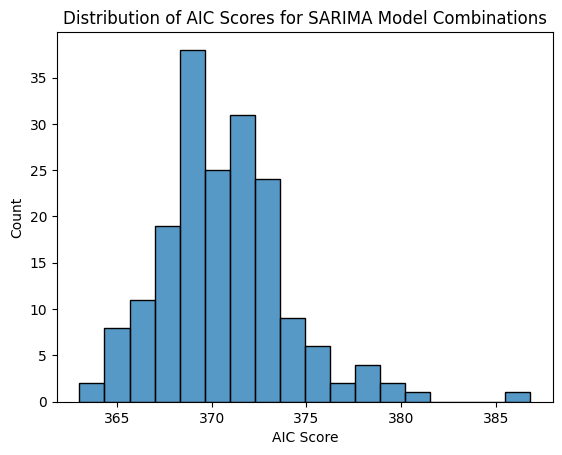

In [18]:
sns.histplot(results["AIC Score"].to_list())
plt.xlabel("AIC Score")
plt.title("Distribution of AIC Scores for SARIMA Model Combinations")

This plot is a distribution the model performance, giving us insight of how our model could possible perform given all the combinations.

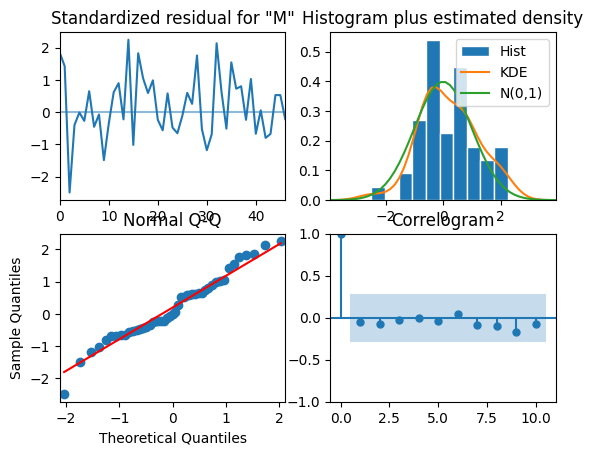

In [14]:
plt.show(best_fitted_model.plot_diagnostics())

Our model residuals are normally distributed, implying that the errors are random. This a good sign that our model is not particularly biased.

# Prediction

We forecast 2 years worth of data.

In [15]:
n_forecast = 24

predictions = best_fitted_model.get_prediction(end=best_fitted_model.nobs + n_forecast)
predictions.predicted_mean


0      0.000000
1     92.996903
2     66.702538
3     54.498006
4     75.298127
        ...    
80   -13.451663
81   -13.587643
82   -13.512165
83   -13.123321
84   -13.262387
Name: predicted_mean, Length: 85, dtype: float64

Text(0.5, 1.0, 'SARIMA Model Fitted and Forecasted Values')

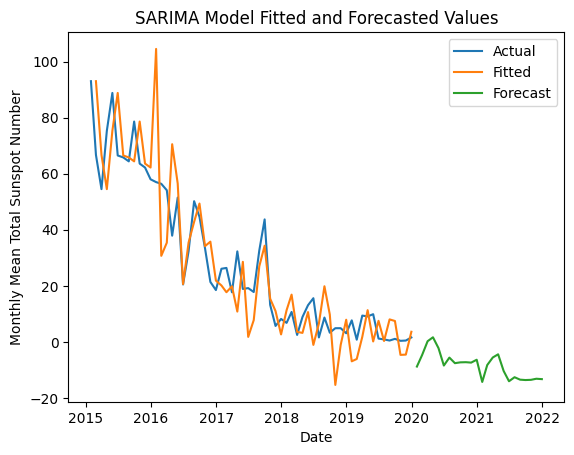

In [19]:
prediction_date_range = pd.date_range(
    filtered_df["Date"].max() + pd.DateOffset(months=1),
    filtered_df["Date"].max() + pd.DateOffset(months=n_forecast),
    freq="ME",
)


sns.lineplot(data=filtered_df, x='Date', y="Monthly Mean Total Sunspot Number", label="Actual")
                                                # We skip the first fitted point to ignore empty values
sns.lineplot(data=filtered_df, x='Date', y=predictions.predicted_mean[:-n_forecast][1:], label="Fitted")
sns.lineplot(x=prediction_date_range, y=predictions.predicted_mean[-n_forecast:], label="Forecast")
plt.title("SARIMA Model Fitted and Forecasted Values")

In [17]:
rmse = root_mean_squared_error(
    filtered_df["Monthly Mean Total Sunspot Number"][1:],
    predictions.predicted_mean[1: len(filtered_df)],
)
rmse

12.994226114907997

Our best fitted model has a root mean squared error (RMSE) of 12.99. A previous fitted model without the seasonal component, has an RMSE of 9.796. Which means that simpler model may be a better fit for this data.

Also if you look at the predictions, it goes below 0, which doesn't make sense for the domain of our data, which are simply counts of sunspots, which will either be 0 or greater.